# Import libraries

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy import ndimage
from matplotlib import colors
import shutil

In [2]:
!pip install pyopenms
import pyopenms
from pyopenms import *

In [3]:
!pip install -U scikit-image
from skimage import io, filters, exposure

In [7]:
pip install Pillow==9.0.0 --user

Note: you may need to restart the kernel to use updated packages.


# Define functions

In [9]:
def plot_spectra_2D_overview(file_location, gamma=0.5, num_colors=256, filter_size=2):
    
    '''
    Generates a 2D overview plot of the mass spectra contained in a mzML file. Applies a logarithmic transformation 
    and a median filter to the data, subtracts the background, and saves the resulting image as a JPEG file. The x-axis of the plot 
    represents the retention time (RT) in seconds and the y-axis represents the mass-to-charge (m/z) values.

    Parameters:
    - file_location (str): the path to the mzML file to be analyzed.
    - gamma (float): gamma correction parameter for image contrast adjustment. Default is 0.5.
    - num_colors (int): the number of colors used to represent the intensity values. Default is 256.
    - filter_size (float): size of Gaussian filter for noise reduction. Default is 2.

    Returns:
    - None. The function generates a plot and saves it as a JPEG file.

    Note: This function requires the following external libraries: numpy, matplotlib, and scipy.

    Example usage: 
    plot_spectra_2D_overview('/content/test_file.mzML')
    
    '''
    
    exp = MSExperiment()
    MzMLFile().load(file_location, exp)

    rows = 500.0
    cols = 500.0
    exp.updateRanges()

    bilip = BilinearInterpolation()
    tmp = bilip.getData()
    tmp.resize(int(rows), int(cols), float())
    bilip.setData(tmp)
    bilip.setMapping_0(0.0, exp.getMinRT(), rows - 1, exp.getMaxRT())
    bilip.setMapping_1(0.0, exp.getMinMZ(), cols - 1, exp.getMaxMZ())
    for spec in exp:
        if spec.getMSLevel() == 1:
            mzs, ints = spec.get_peaks()
            rt = spec.getRT()
            for i in range(0, len(mzs)):
                bilip.addValue(rt, mzs[i], ints[i])

    data = np.ndarray(shape=(int(cols), int(rows)), dtype=np.float64)
    for i in range(int(rows)):
        for j in range(int(cols)):
            data[i][j] = bilip.getData().getValue(i, j)

    ms_map = np.power(data, gamma)
    
    # Represent intensity values with specified number of colors
    bins = np.linspace(0, np.max(ms_map), num_colors)
    ms_map = np.digitize(ms_map, bins)
    
    # Normalize intensity values using highest peak
    ms_map = ms_map / np.max(ms_map)
    
    # Apply Gaussian filter for noise reduction
    ms_map = ndimage.gaussian_filter(ms_map, sigma=filter_size)
    ms_map *= (255.0/ms_map.max())

    # Display the normalized map using Matplotlib
    plt.imshow(np.rot90(ms_map), cmap="jet")
    plt.title("")
    plt.axis('off')
    plt.tight_layout()
    basename = os.path.splitext(file_location)[0]

    plt.savefig(f'{basename}.jpeg', bbox_inches='tight', pad_inches = 0, dpi = 300)

# plot_spectra_2D_overview("Positive_P9_T5.mzML")

# Identifying a good data set

In [ ]:
datasets = pd.read_html('https://www.metabolomicsworkbench.org/data/DRCCStudySummary.php?Mode=StudySummary&SortBy=Study%20ID&AscDesc=desc&ResultsPerPage=2000')[2]

In [ ]:
(datasets
 .rename(columns = {'Download(* : Contains raw data)' : 'file_size'})
 .sort_values(by = 'Samples', ascending = False)
 .query("(400 < Samples < 600) and Analysis == 'LC-MS#'")
 .sample(10, random_state = 2)
)

,Study ID,Study Title,Species,Institute,Analysis,Released,Version,Samples,file_size
827,ST001423,Aspirin Metabolomics in Colorectal Cancer Chem...,Homo sapiens,Emory University,LC-MS#,2020-07-20,1,494,Uploaded data (289G)* (Data format:raw(Thermo))
906,ST001335,"Air Pollution, Placenta Function, and Birth Ou...",Homo sapiens,Emory University,LC-MS#,2022-09-27,1,530,Uploaded data (122.7G)* (Data format:raw(Thermo))
428,ST001930,Integrated molecular response of exposure to t...,Homo sapiens,Icahn School of Medicine at Mount Sinai,LC-MS#,2021-10-29,1,420,"Uploaded data (535.8G)* (Data format:mzXML, ra..."
870,ST001374,Untargeted Metabolomics for fruit juice authen...,Malus domestica;Citrus sinensis,China Agricultural University,LC-MS#,2020-05-22,1,597,Uploaded data (22.5G)* (Data format:wiff)
129,ST002276,Machine Learning Reveals Lipidome Dynamics in ...,Mus musculus,Georgia Institute of Technology,LC-MS#,2022-09-28,1,459,Uploaded data (111.1G)* (Data format:raw(Thermo))
648,ST001692,Perfluoroalkyl substances and lipid compositio...,Homo sapiens,Icahn School of Medicine at Mount Sinai,LC-MS#,2022-03-11,1,527,Uploaded data (191.6G)* (Data format:mzXML)
1307,ST000923,Longitudinal Metabolomics of the Human Microbi...,Homo sapiens,Broad Institute of MIT and Harvard,LC-MS#,2018-02-07,1,546,Uploaded data (352.3G)* (Data format:raw(Thermo))
1027,ST001212,"Fish-oil supplementation in pregnancy, child m...",Homo sapiens,University of Copenhagen,LC-MS#,2019-09-23,1,577,Uploaded data (1M)
924,ST001317,"Dynamics of Exposure, Phthalates, and Asthma i...",Homo sapiens,Icahn School of Medicine at Mount Sinai,LC-MS#,2021-08-31,1,448,Uploaded data (62.4G)* (Data format:d)
1230,ST001002,A pilot study of urine metabolomics in two fem...,Homo sapiens,Mayo Clinic,LC-MS#,2022-12-15,1,516,Uploaded data (18.9M)


In [ ]:
groups = pd.read_html('https://www.metabolomicsworkbench.org/data/subject_fetch.php?STUDY_ID=ST002276&STUDY_TYPE=MS&RESULT_TYPE=5')[1]
processed_groups = (groups
                    .rename(columns = lambda x: x.replace(' ', '_')) 
                    .loc[:, ['Sample_name', 'phenotype']]
                    )
CTR = processed_groups.query("phenotype == 'control'").Sample_name
DKO = processed_groups.query("phenotype == 'DKO'").Sample_name

print(f'Number of samples in the:')
print(f'CTR group: {len(CTR)}')
print(f'DKO group: {len(DKO)}')

Number of samples in the:
CTR group: 238
DKO group: 221


# Convert mzML to images

Working on : N15_T20
N15_T20 is done
Working on : NC10_T1
NC10_T1 is done
Working on : NC10_T10
NC10_T10 is done
Working on : NC10_T11
NC10_T11 is done
Working on : NC10_T12
NC10_T12 is done
Working on : NC10_T13
NC10_T13 is done
Working on : NC10_T14
NC10_T14 is done
Working on : NC10_T15
NC10_T15 is done
Working on : NC10_T16
NC10_T16 is done
Working on : NC10_T17
NC10_T17 is done
Working on : NC10_T18
NC10_T18 is done
Working on : NC10_T2
NC10_T2 is done
Working on : NC10_T3
NC10_T3 is done
Working on : NC10_T4
NC10_T4 is done
Working on : NC10_T5
NC10_T5 is done
Working on : NC10_T6
NC10_T6 is done
Working on : NC10_T7
NC10_T7 is done
Working on : NC10_T9
NC10_T9 is done
Working on : NC11_T1
NC11_T1 is done
Working on : NC11_T10
NC11_T10 is done
Working on : NC11_T11
NC11_T11 is done
Working on : NC11_T12
NC11_T12 is done
Working on : NC11_T13
NC11_T13 is done
Working on : NC11_T14
NC11_T14 is done
Working on : NC11_T15
NC11_T15 is done
Working on : NC11_T16
NC11_T16 is done
Workin

KeyboardInterrupt: 

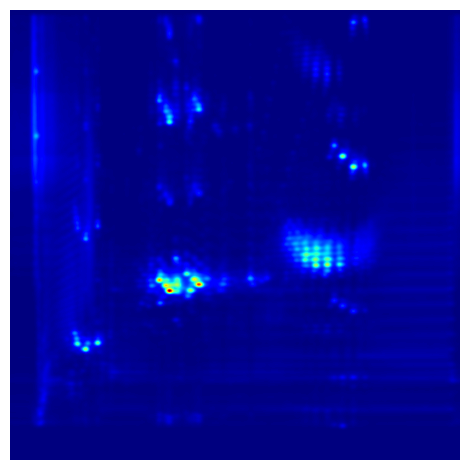

In [12]:
# Directory to search in
dir_path =  os.getcwd()

# Extension to filter by
extension = '*.mzML'

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(dir_path):
    # Use glob to find files with the desired extension
    files_with_extension = glob.glob(os.path.join(root, extension))
    for file_path in files_with_extension:

        filename = os.path.basename(file_path)
        basename = os.path.splitext(filename)[0]
        
        print(f'Working on : {basename}')
        plot_spectra_2D_overview(filename)
        print(f'{basename} is done')

# Move datafiles to correct folders (according to which group they belong to)

In [ ]:
for_train_test_split = (pd.DataFrame(
    (pd.concat([CTR, DKO], axis = 0))
).assign(treated = lambda df: df.Sample_name
         .mask(df.Sample_name.isin(CTR), other = 0)
         .mask(df.Sample_name.isin(DKO), other = 1)
        )
                       )
for_train_test_split

,Sample_name,treated
0,N15_T20,0
1,NC10_T1,0
2,NC10_T10,0
3,NC10_T11,0
4,NC10_T12,0
...,...,...
454,P9_T5,1
455,P9_T6,1
456,P9_T7,1
457,P9_T8,1


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(for_train_test_split.Sample_name, 
                                                  for_train_test_split.treated, 
                                                  test_size=0.2, 
                                                  stratify = for_train_test_split.treated, 
                                                  random_state=42)

print(X_train.shape, X_val.shape)
print(y_train.value_counts(normalize = True))
print(y_val.value_counts(normalize = True))

(367,) (92,)
0    0.517711
1    0.482289
Name: treated, dtype: float64
0    0.521739
1    0.478261
Name: treated, dtype: float64


In [ ]:
# Directory to search in
dir_path = os.getcwd()

path_train =  os.path.join(dir_path, 'train')
path_train_CTR =  os.path.join(dir_path, 'train', 'CTR')
path_train_DKO =  os.path.join(dir_path, 'train', 'DKO')

path_val = os.path.join(dir_path, 'val')
path_val_CTR =  os.path.join(dir_path, 'val', 'CTR')
path_val_DKO =  os.path.join(dir_path, 'val', 'DKO')


os.makedirs(path_train, exist_ok= True)
os.makedirs(path_train_CTR, exist_ok= True)
os.makedirs(path_train_DKO, exist_ok= True)


os.makedirs(path_val,exist_ok= True)
os.makedirs(path_val_CTR,exist_ok= True)
os.makedirs(path_val_DKO,exist_ok= True)

# Extension to filter by
extension = '*.jpeg'

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(dir_path):
    # Use glob to find files with the desired extension
    files_with_extension = glob.glob(os.path.join(root, extension))
    for file_path in files_with_extension:

        filename = os.path.basename(file_path)
        basename = os.path.splitext(filename)[0]
        
        print(basename)
        
        if X_train.isin([basename]).any():
            if CTR.isin([basename]).any():
                shutil.copy(os.path.join(dir_path, filename), path_train_CTR)
            else:
                shutil.copy(os.path.join(dir_path, filename), path_train_DKO)
        
        if X_val.isin([basename]).any():
            if CTR.isin([basename]).any():
                shutil.copy(os.path.join(dir_path, filename), path_val_CTR)
            else:
                shutil.copy(os.path.join(dir_path, filename), path_val_DKO)